## Libraries

In [1]:
import gymnasium as gym
from gym import spaces
import numpy as np
import pandas as pd
import pygame
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Boat

#### Simulator:

In [2]:
class BoatEnvSimulator(gym.Env):
    metadata = {'render_modes': [None]}

    def __init__(self, east_wind_prob=0.7, west_wind_prob=0.3, episodes=100, steps=1000, seed=None):
        super().__init__()
        assert east_wind_prob + west_wind_prob <= 1, 'Invalid wind probabilities'
        self.east_wind_prob = east_wind_prob
        self.west_wind_prob = west_wind_prob
        self.observation_space = spaces.Discrete(2)
        self.action_space = spaces.Discrete(2)
        self.episodes = episodes
        self.steps = steps
        self.transition_counts = {}
        self.state_rewards = {}
        self.rng = np.random.default_rng(seed)
        self.prob_wind = [east_wind_prob, west_wind_prob, 1 - east_wind_prob - west_wind_prob]
        pygame.init()
        self.screen_width, self.screen_height = 600, 400
        self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
        pygame.display.set_caption("Boat Environment")
        self.bg_color = (173, 216, 230)
        self.line_color = (0, 0, 0)
        self.end_line_color = (255, 165, 0)
        self.boat_image = pygame.image.load('package_RL_JBM/boat.jpg')
        self.boat_image = pygame.transform.scale(self.boat_image, (200, 100))  

    def get_info(self, wind):
        direction = {1: 'East Wind', -1: 'West Wind', 0: 'No Wind'}
        return {'Wind': direction[wind]}

    def reset(self):
        self.state = 0
        self.render()
        return self.state, self.get_info(0)

    def step(self, action):
        wind = self.rng.choice([1, -1, 0], p=self.prob_wind)  # Randomly choose wind direction or no wind
        move_direction = 1 if action == 1 else -1  # 1 for right, -1 for left
        reward = 0

        # Determine next state and calculate reward based on the current state, action, and wind
        if (wind == move_direction or wind == 0):  # Move if wind and motor direction align or no wind
            if self.state == 0 and action == 1:
                self.state = 1  # Move right from left
                reward = 2
            elif self.state == 1 and action == 0:
                self.state = 0  # Move left from right
                reward = 2
        else:
            # Handling no movement due to opposing wind and motor direction
            if self.state == 0:
                reward = 1 if action == 0 else 0  # Hitting left wall or staying due to wind
            elif self.state == 1:
                reward = 4 if action == 1 else 3  # Hitting right wall or staying due to wind

        terminated = False
        truncated = False
        self.render()
        return self.state, reward, terminated, truncated, self.get_info(wind)
    
    def get_transitions(self, state, action):
        transitions = []
        action_direction = 1 if action == 1 else -1  # 1 for right, -1 for left

        # Iterate over possible wind effects
        for wind, prob in zip([1, -1, 0], self.prob_wind):
            move_direction = action_direction
            if wind == move_direction or wind == 0:  # Movement happens
                new_state = 1 if state == 0 and action == 1 else 0 if state == 1 and action == 0 else state
            else:
                new_state = state  # No movement due to opposing wind

            # Determine reward based on new state, current state, action, and wind
            if new_state != state:  # Successfully moved to the other state
                reward = 2
            else:
                if state == 0:
                    reward = 1 if action == 0 else 0  # No move or hit the wall
                elif state == 1:
                    reward = 4 if action == 1 else 3  # Hit the wall or no move

            transitions.append((prob, new_state, reward))
        
        return transitions

    def render(self, mode='human'):
        # Clear the screen with background color
        self.screen.fill(self.bg_color)

        # Draw vertical lines: orange for ends, black for middle
        pygame.draw.line(self.screen, self.end_line_color, (0, 0), (0, self.screen_height), 10)  # Left orange line
        pygame.draw.line(self.screen, self.end_line_color, (self.screen_width - 10, 0), (self.screen_width - 10, self.screen_height), 10)  # Right orange line
        pygame.draw.line(self.screen, self.line_color, (self.screen_width // 2, 0), (self.screen_width // 2, self.screen_height), 10)  # Middle black line

        # Draw the boat based on the state
        if self.state == 0:
            # Boat on the left side
            self.screen.blit(self.boat_image, (self.screen_width // 4 - 100, self.screen_height // 2 - 50))  # Adjust for larger boat
        else:
            # Boat on the right side
            self.screen.blit(self.boat_image, (3 * self.screen_width // 4 - 100, self.screen_height // 2 - 50))  # Adjust for larger boat

        # Update the display
        pygame.display.flip()

    def run_simulation(self):
        for _ in range(self.episodes):
            state, _ = self.reset()
            for _ in range(self.steps):
                action = np.random.choice([0, 1], p=[0.5, 0.5])
                next_state, reward, terminated, truncated, _ = self.step(action)
                transition_key = (state, action, next_state)
                reward_key = (state, action, next_state, reward)
                if transition_key not in self.transition_counts:
                    self.transition_counts[transition_key] = 0
                self.transition_counts[transition_key] += 1
                if reward_key not in self.state_rewards:
                    self.state_rewards[reward_key] = 0
                self.state_rewards[reward_key] += 1
                state = next_state
                if terminated or truncated:
                    break

    def close(self):
        pygame.quit()

#### Solver:

In [3]:
class BoatSolver:
    def __init__(self, env, gamma=0.99, theta=0.01, use_value_iteration=False):
        self.env = env
        self.gamma = gamma
        self.theta = theta
        self.V = np.zeros(env.observation_space.n)
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))
        self.policy = np.zeros(env.observation_space.n, dtype=int)
        self.use_value_iteration = use_value_iteration
        self.V_history = []
        self.Q_history = []
        self.policy_history = []

    def value_iteration(self):
        while True:
            delta = 0
            for s in range(self.env.observation_space.n):
                v = self.V[s]
                # Calculate action values and update V[s] based on these values
                action_values = [self.expected_return(s, a) for a in range(self.env.action_space.n)]
                max_action_value = max(action_values)
                self.V[s] = max_action_value
                delta = max(delta, abs(v - self.V[s]))
                
                # Check if policy change is needed
                new_policy = np.argmax(action_values)
                if new_policy != self.policy[s]:
                    self.policy[s] = new_policy  # Update policy at state s if there is a change
                
            self.V_history.append(self.V.copy())
            self.Q_history.append(self.Q.copy())
            self.policy_history.append(self.policy.copy())  # Record policy after each iteration
        
            if delta < self.theta:
                break

    def policy_evaluation(self):
        while True:
            delta = 0
            for s in range(self.env.observation_space.n):
                v = self.V[s]
                self.V[s] = max(self.expected_return(s, a) for a in range(self.env.action_space.n))
                delta = max(delta, abs(v - self.V[s]))
                self.V_history.append(self.V.copy())
            if delta < self.theta:
                break

    def policy_improvement(self):
        policy_stable = True
        for s in range(self.env.observation_space.n):
            old_action = self.policy[s]
            action_values = [self.expected_return(s, a) for a in range(self.env.action_space.n)]
            self.Q[s] = action_values
            self.policy[s] = np.argmax(action_values)
            self.Q_history.append(self.Q.copy())
            if old_action != self.policy[s]:
                policy_stable = False
        self.policy_history.append(self.policy.copy())
        return policy_stable

    def expected_return(self, state, action):
        return sum(prob * (reward + self.gamma * self.V[next_state]) for prob, next_state, reward in self.env.get_transitions(state, action))

    def plot_policy(self):
        plt.figure(figsize=(8, 4))
        ax = plt.gca()  # Get current axis

        policy_arrows = ['←', '→']  # Only two actions: left and right
        policy_labels = [policy_arrows[action] for action in self.policy]

        # Create grid layout
        ax.set_xlim(0, len(policy_labels))
        ax.set_ylim(0, 1)
        ax.set_xticks([0.5 + i for i in range(len(policy_labels))])  # Positioning x-ticks in the middle of the cells
        ax.set_xticklabels(['State ' + str(i) for i in range(len(policy_labels))])  # Labeling states
        ax.set_yticks([])  # No y-ticks needed

        # Add grid lines
        for i in range(len(policy_labels) + 1):
            ax.add_patch(patches.Rectangle((i, 0), 1, 1, fill=None, edgecolor='black', lw=2))

        # Plot arrows in the middle of each grid cell
        for i, label in enumerate(policy_labels):
            ax.text(i + 0.5, 0.5, label, ha='center', va='center', fontsize=30, fontweight='bold')

        plt.title("Optimal Policy")
        plt.xlabel('State')
        plt.show()

    def plot_convergence(self):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 3, 1)
        plt.plot([np.mean(v) for v in self.V_history])
        plt.title('Convergence of State-Value Function')
        plt.xlabel('Iteration')
        plt.ylabel('Average State-Value')

        plt.subplot(1, 3, 2)
        plt.plot([np.mean(q) for q in self.Q_history])
        plt.title('Convergence of Action-Value Function')
        plt.xlabel('Iteration')
        plt.ylabel('Average Action-Value')

        plt.subplot(1, 3, 3)
        policy_changes = [np.sum(p != self.policy_history[i - 1]) if i > 0 else self.env.observation_space.n for i, p in enumerate(self.policy_history)]
        plt.plot(policy_changes)
        plt.title('Policy Changes per Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Number of Changed Actions')

        plt.tight_layout()
        plt.show()

    def solve(self):
        if self.use_value_iteration:
            self.value_iteration()
        else:
            while True:
                self.policy_evaluation()
                if self.policy_improvement():
                    break
        self.plot_policy()
        self.plot_convergence()
        return self.policy, self.V, self.Q

#### Run:

**Value Iteration**

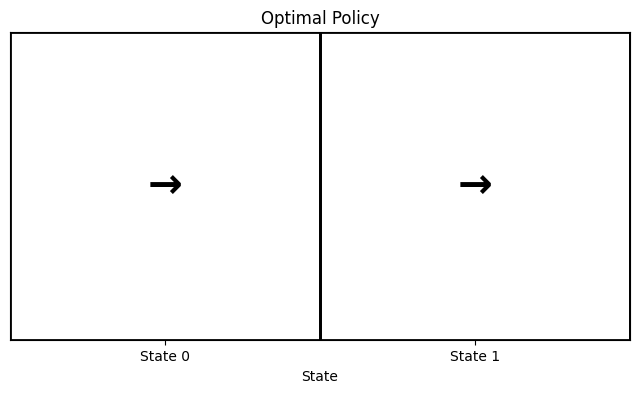

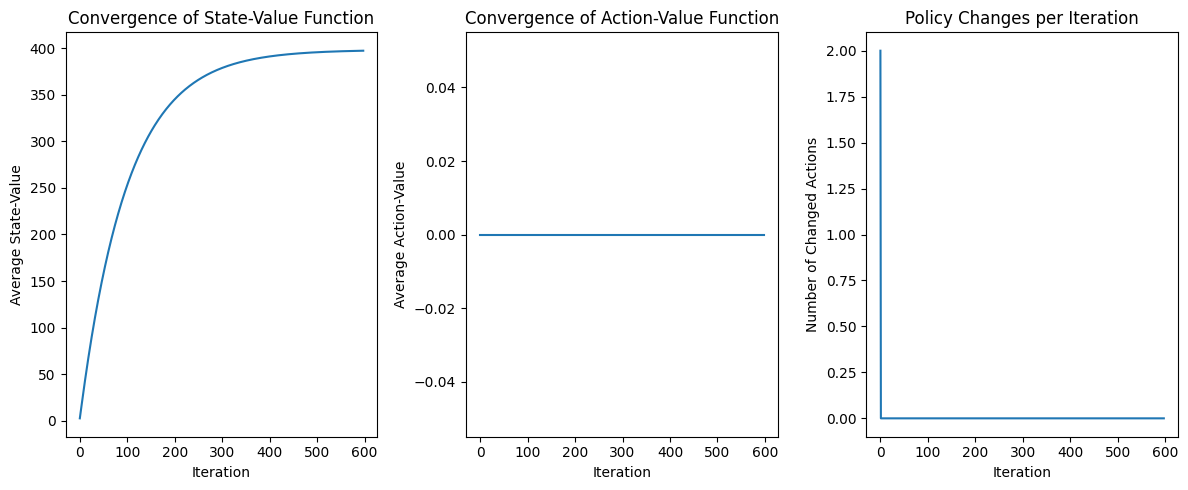

Policy from Value Iteration: [1 1]
Value Function from Value Iteration: [395.32002843 399.01846371]


In [6]:
# Initialize the Boat environment with episodes and steps.
env = BoatEnvSimulator(episodes=100, steps=100, seed=42)

# Instantiate Solver with Value Iteration.
solver_value_iteration = Solver(env, gamma=0.99, theta=0.01, use_value_iteration=True)
policy_vi, V_vi, Q_vi = solver_value_iteration.solve()

# Print outputs from Value Iteration
print("Policy from Value Iteration:", policy_vi)
print("Value Function from Value Iteration:", V_vi)

**Policy Iteration**

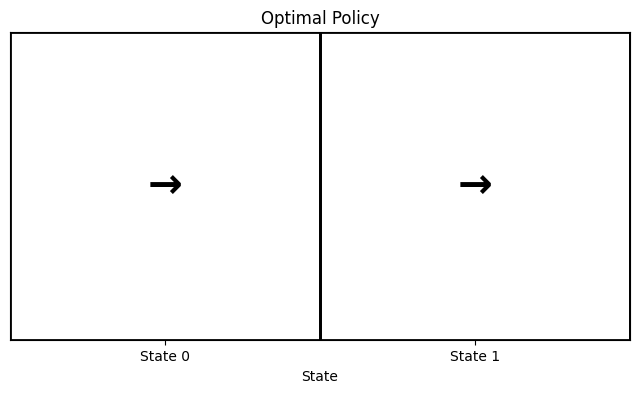

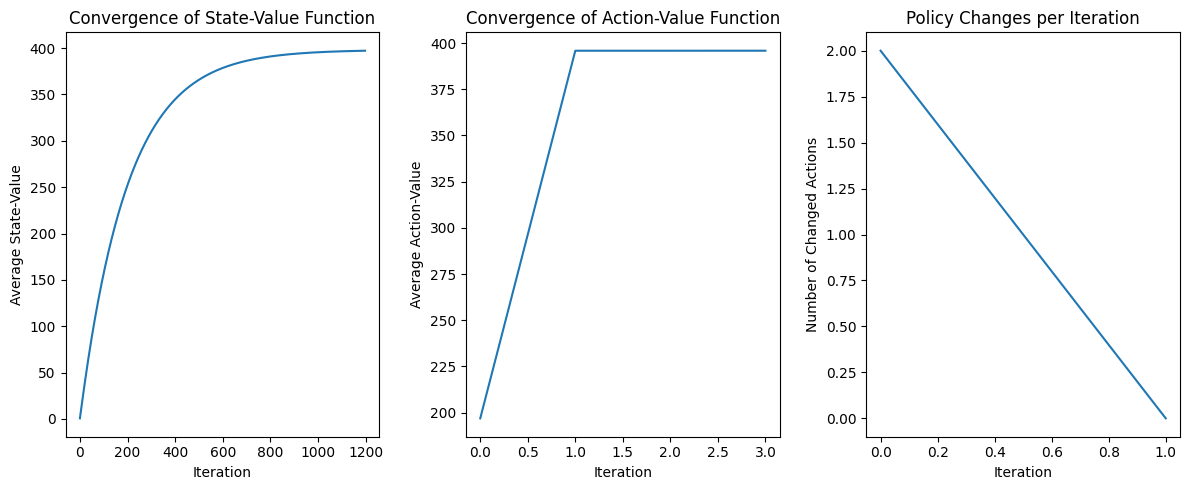

Policy from Policy Iteration: [1 1]
Value Function from Policy Iteration: [395.3298438  399.02827907]


: 

In [7]:
# Instantiate Solver with Policy Iteration.
solver_policy_iteration = BoatSolver(env, gamma=0.99, theta=0.01, use_value_iteration=False)
policy_pi, V_pi, Q_pi = solver_policy_iteration.solve()

# Print outputs from Policy Iteration
print("Policy from Policy Iteration:", policy_pi)
print("Value Function from Policy Iteration:", V_pi)


## Gridworld

#### Simulator:

In [26]:
# Grid World
class GridWorldEnv(gym.Env):
    metadata = {'render_modes': [None]}

    def __init__(self, gamma=0.25, episodes=10000, steps=1000, seed=None):
        super(GridWorldEnv, self).__init__()
        self.grid_size = (6, 6)
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.grid_size[0]),
            spaces.Discrete(self.grid_size[1])
        ))

        self.walls = [(i, 2) for i in [0, 1]] + [(i, 2) for i in [3, 4, 5]] + [(3, j) for j in [2, 3, 4]]
        self.terminal_states = {
            (5, 0): -50,  # Red (bad) state
            (1, 4): -50,  # Red (bad) state
            (5, 5): 100   # Green (good) state
        }
        self.default_reward = -1
        self.gamma = gamma
        self.episodes = episodes
        self.steps = steps
        self.rng = np.random.default_rng(seed)
        self.state = (0, 0)

        # Pygame setup
        pygame.init()
        self.window_size = 600  # 600x600 window size
        self.grid_pixel_size = self.window_size // self.grid_size[0]
        self.screen = pygame.display.set_mode((self.window_size, self.window_size))
        pygame.display.set_caption("GridWorld")

        # Load player (robot) image
        self.robot_image = pygame.image.load('package_RL_JBM/robot.png.jpg')
        # Scale it to fit the grid
        self.robot_image = pygame.transform.scale(self.robot_image, (self.grid_pixel_size, self.grid_pixel_size))

        # Colors
        self.wall_color = (0, 45, 98)  # Dark blue: #002D62
        self.bad_state_color = (136, 8, 8)  # Red: #880808
        self.good_state_color = (0, 106, 78)  # Green: #006A4E

    def reset(self):
        self.state = (0, 0)
        return self.state

    def step(self, action):
        if self.rng.random() < self.gamma:
            action = self.rng.choice([0, 1, 2, 3])
        
        i, j = self.state

        if action == 0:
            next_state = (max(i - 1, 0), j)
        elif action == 1:
            next_state = (i, min(j + 1, self.grid_size[1] - 1))
        elif action == 2:
            next_state = (min(i + 1, self.grid_size[0] - 1), j)
        elif action == 3:
            next_state = (i, max(j - 1, 0))
        
        if next_state in self.walls:
            next_state = self.state
        
        if next_state in self.terminal_states:
            reward = self.terminal_states[next_state]
            done = True
        else:
            reward = self.default_reward
            done = False

        self.state = next_state
        return self.state, reward, done, {}

    def get_transitions(self, state, action):
        transitions = []
        i, j = state
        directions = [(i - 1, j), (i, j + 1), (i + 1, j), (i, j - 1)]  # Up, Right, Down, Left
        next_state = directions[action]
        if next_state[0] < 0 or next_state[0] >= self.env.grid_size[0] or next_state[1] < 0 or next_state[1] >= self.env.grid_size[1]:
            next_state = state  # Handle out-of-bounds by staying in the current state
        if next_state in self.env.walls:
            next_state = state  # Handle wall collision by staying in the current state

        if next_state in self.env.terminal_states:
            reward = self.env.terminal_states[next_state]
        else:
            reward = self.env.default_reward

        # The probability of taking the intended action unless influenced by randomness (gamma)
        prob = 1 - self.env.gamma + (self.env.gamma / self.env.action_space.n) if action == action else (self.env.gamma / self.env.action_space.n)
        transitions.append((prob, next_state, reward))

        # Adding random action influence
        for a in range(self.env.action_space.n):
            if a != action:
                alternative_next_state = directions[a]
                if alternative_next_state[0] < 0 or alternative_next_state[0] >= self.env.grid_size[0] or alternative_next_state[1] < 0 or alternative_next_state[1] >= self.env.grid_size[1]:
                    alternative_next_state = state  # Handle out-of-bounds by staying in the current state
                if alternative_next_state in self.env.walls:
                    alternative_next_state = state  # Handle wall collision by staying in the current state

                transitions.append((self.env.gamma / self.env.action_space.n, alternative_next_state, self.env.default_reward))

        return transitions


    def get_next_state_reward(self, state, action):
        # This function computes the next state and reward for a given action without randomness
        i, j = state
        if action == 0:
            next_state = (max(i - 1, 0), j)
        elif action == 1:
            next_state = (i, min(j + 1, self.grid_size[1] - 1))
        elif action == 2:
            next_state = (min(i + 1, self.grid_size[0] - 1), j)
        elif action == 3:
            next_state = (i, max(j - 1, 0))

        if next_state in self.walls:
            next_state = state

        if next_state in self.terminal_states:
            reward = self.terminal_states[next_state]
        else:
            reward = self.default_reward

        return next_state, reward

    def render(self, mode='human'):
        self.screen.fill((255, 255, 255))  # White background

        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                rect = pygame.Rect(j * self.grid_pixel_size, i * self.grid_pixel_size, self.grid_pixel_size, self.grid_pixel_size)
                
                # Draw walls (dark blue)
                if (i, j) in self.walls:
                    pygame.draw.rect(self.screen, self.wall_color, rect)

                # Draw terminal states (red for bad states, green for good states)
                elif (i, j) in self.terminal_states:
                    color = self.good_state_color if self.terminal_states[(i, j)] > 0 else self.bad_state_color
                    pygame.draw.rect(self.screen, color, rect)

                # Draw the agent as a robot image
                elif (i, j) == self.state:
                    self.screen.blit(self.robot_image, rect)

                # Draw grid lines
                pygame.draw.rect(self.screen, (0, 0, 0), rect, 1)

        pygame.display.flip()

    def close(self):
        pygame.quit()

#### Solver

In [33]:
import numpy as np

class GridWorldSolver:
    def __init__(self, env, gamma=0.99, theta=0.01, use_value_iteration=False):
        self.env = env
        self.gamma = gamma
        self.theta = theta
        self.state_space_size = env.grid_size[0] * env.grid_size[1]
        self.V = np.zeros(self.state_space_size)
        self.Q = np.zeros((self.state_space_size, env.action_space.n))
        self.policy = np.zeros(self.state_space_size, dtype=int)
        self.use_value_iteration = use_value_iteration
        self.V_history = []
        self.Q_history = []
        self.policy_history = []

    def state_to_index(self, state):
        i, j = state
        return i * self.env.grid_size[1] + j

    def index_to_state(self, index):
        return (index // self.env.grid_size[1], index % self.env.grid_size[1])

    def get_transitions(self, state, action):
        transitions = []
        i, j = state
        directions = [(i - 1, j), (i, j + 1), (i + 1, j), (i, j - 1)]  # Up, Right, Down, Left
        if 0 <= action < 4:
            next_state = directions[action]
            if next_state[0] < 0 or next_state[0] >= self.env.grid_size[0] or next_state[1] < 0 or next_state[1] >= self.env.grid_size[1] or next_state in self.env.walls:
                next_state = state  # Revert to current state if moves into wall or out of bounds
            
            if next_state in self.env.terminal_states:
                reward = self.env.terminal_states[next_state]
                transitions.append((1, next_state, reward))
            else:
                reward = self.env.default_reward
                transitions.append((1, next_state, reward))
                
        return transitions

    def expected_return(self, state, action):
        index = self.state_to_index(state)
        return sum(prob * (reward + self.gamma * self.V[self.state_to_index(next_state)])
                   for prob, next_state, reward in self.get_transitions(state, action))

    def value_iteration(self):
        while True:
            delta = 0
            for s in range(self.state_space_size):
                state = self.index_to_state(s)
                v = self.V[s]
                action_values = [self.expected_return(state, a) for a in range(self.env.action_space.n)]
                max_action_value = max(action_values)
                self.V[s] = max_action_value
                delta = max(delta, abs(v - self.V[s]))
                
                new_policy = np.argmax(action_values)
                if new_policy != self.policy[s]:
                    self.policy[s] = new_policy
                
            self.V_history.append(self.V.copy())
            if delta < self.theta:
                break

    def policy_evaluation(self):
        while True:
            delta = 0
            for s in range(self.state_space_size):
                state = self.index_to_state(s)
                v = self.V[s]
                self.V[s] = max(self.expected_return(state, a) for a in range(self.env.action_space.n))
                delta = max(delta, abs(v - self.V[s]))
            self.V_history.append(self.V.copy())
            if delta < self.theta:
                break

    def policy_improvement(self):
        policy_stable = True
        for s in range(self.state_space_size):
            state = self.index_to_state(s)
            old_action = self.policy[s]
            action_values = [self.expected_return(state, a) for a in range(self.env.action_space.n)]
            self.Q[s] = action_values
            self.policy[s] = np.argmax(action_values)
            if old_action != self.policy[s]:
                policy_stable = False
        self.policy_history.append(self.policy.copy())
        return policy_stable

    def plot_policy(self):
        grid_size = self.env.grid_size
        policy_grid = np.array(self.policy).reshape(grid_size)
        action_symbols = {0: '↑', 1: '→', 2: '↓', 3: '←'}
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks(np.arange(grid_size[1]+1) - 0.5, minor=True)
        ax.set_yticks(np.arange(grid_size[0]+1) - 0.5, minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())

        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                action = policy_grid[i, j]
                if (i, j) in self.env.walls:
                    continue  # Skip walls
                ax.text(j, grid_size[0] - i - 1, action_symbols[action], ha='center', va='center', fontsize=16, color='blue')

        plt.title("Optimal Policy")
        plt.show()

    def plot_convergence(self):
        plt.figure(figsize=(18, 6))
        plt.subplot(131)
        plt.plot([np.mean(v) for v in self.V_history])
        plt.title('Convergence of State-Value Function')
        plt.xlabel('Iteration')
        plt.ylabel('Average State-Value')

        plt.subplot(132)
        plt.plot([np.mean(q) for q in self.Q_history])
        plt.title('Convergence of Action-Value Function')
        plt.xlabel('Iteration')
        plt.ylabel('Average Action-Value')

        plt.subplot(133)
        policy_changes = [np.sum(p != self.policy_history[i - 1]) if i > 0 else 0 for i, p in enumerate(self.policy_history)]
        plt.plot(policy_changes)
        plt.title('Policy Changes per Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Number of Changed Actions')

        plt.tight_layout()
        plt.show()


    def solve(self):
        if self.use_value_iteration:
            self.value_iteration()
        else:
            while True:
                self.policy_evaluation()
                if self.policy_improvement():
                    break
        self.plot_policy()
        self.plot_convergence()
        return self.policy, self.V, self.Q



#### Run:

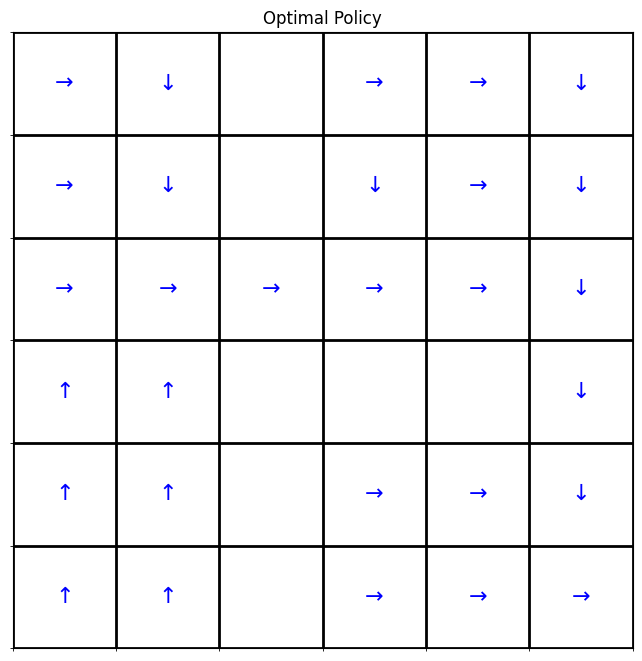

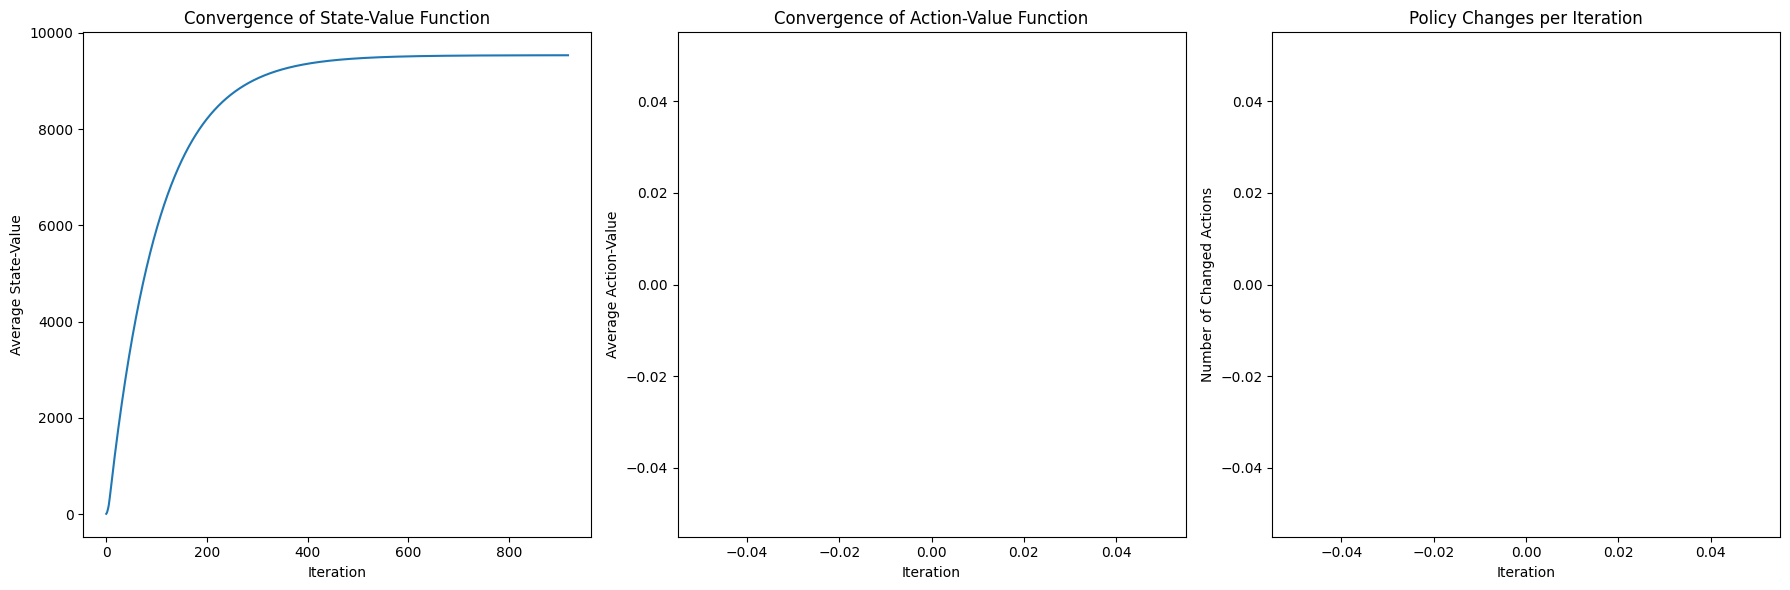

(array([1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2,
        1, 2, 0, 0, 1, 1, 1, 2, 0, 0, 1, 1, 1, 1]),
 array([9125.53994229, 9218.73715643, 9312.87575657, 9407.96525166,
        9504.0152467 , 9601.03544371, 9218.73715643, 9312.87575657,
        9407.96525166, 9504.0152467 , 9601.03544371, 9699.03564271,
        9312.87575657, 9407.96525166, 9504.0152467 , 9601.03544371,
        9699.03564271, 9798.02574271, 9218.746999  , 9312.88559914,
        9407.97509423, 9699.03564271, 9798.02574271, 9898.01574271,
        9125.55952901, 9218.75674315, 9699.03564271, 9798.02574271,
        9898.01574271, 9999.01574271, 9033.30393372, 9125.56917572,
        9798.02574271, 9898.01574271, 9999.01574271, 9999.01574271]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],


In [35]:
denv = GridWorldEnv()
solver = GridWorldSolver(env, use_value_iteration=True)
solver.solve()



## Geosearch

#### Simulator:

In [44]:
import gym
from gym import spaces
import numpy as np
import pygame
import sys

class GeosearchEnv(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, A=0.75):
        super(GeosearchEnv, self).__init__()
        self.grid_size = 25
        self.action_space = spaces.Discrete(4)  # Up, down, left, right
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.grid_size, self.grid_size), dtype=np.float32)

        self.mu1 = np.array([20, 20])
        self.sigma1 = np.array([1, 1])
        self.rho1 = 0.25
        self.mu2 = np.array([10, 10])
        self.sigma2 = np.array([1, 1])
        self.rho2 = -0.25
        self.A = A

        self.reward_matrix = self.compute_rewards()
        self.state = (0, 0)  # Starting position

        # Pygame setup
        pygame.init()
        self.cell_size = 20
        self.window_size = self.grid_size * self.cell_size
        self.screen = pygame.display.set_mode((self.window_size, self.window_size))
        pygame.display.set_caption("Geosearch Environment")

    def gaussian_distribution(self, x, y, mu, sigma, rho):
        x_mu = x - mu[0]
        y_mu = y - mu[1]
        sigma_x, sigma_y = sigma
        rho_term = 2 * rho * x_mu * y_mu / (sigma_x * sigma_y)
        exponent = -1 / (2 * (1 - rho ** 2)) * ((x_mu ** 2 / sigma_x ** 2) - rho_term + (y_mu ** 2 / sigma_y ** 2))
        return (1 / (2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - rho ** 2))) * np.exp(exponent)

    def compute_rewards(self):
        rewards = np.zeros((self.grid_size, self.grid_size))
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                f1 = self.gaussian_distribution(x, y, self.mu1, self.sigma1, self.rho1)
                f2 = self.gaussian_distribution(x, y, self.mu2, self.sigma2, self.rho2)
                rewards[x, y] = self.A * f1 + (1 - self.A) * f2
        return rewards

    def render(self, mode='human'):
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                color_intensity = int(255 * self.reward_matrix[x, y] / np.max(self.reward_matrix))
                pygame.draw.rect(self.screen, (0, 0, color_intensity), (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size))
        
        # Draw agent
        agent_pos = (self.state[0] * self.cell_size, self.state[1] * self.cell_size)
        pygame.draw.rect(self.screen, (255, 0, 0), (agent_pos[0], agent_pos[1], self.cell_size, self.cell_size))
        
        pygame.display.flip()

    def step(self, action):
        # Implement action effect here
        return self.state, 0, False, {}  # Simplified for demonstration

    def reset(self):
        self.state = (0, 0)
        return self.state

    def close(self):
        pygame.quit()


KeyboardInterrupt: 

: 

## Visualizing envs

In [40]:
import pygame
import sys

def main():
    env = GeosearchEnv()  # Create an instance of the environment
    env.reset()  # Reset the environment to the initial state

    # Render the initial state of the environment
    env.render()

    # Keep the window open until it is closed by the user
    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()

if __name__ == "__main__":
    main()


AttributeError: 'GeosearchEnv' object has no attribute 'gaussian_distribution'